# Import Packages

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 200)

# Read Data 

In [3]:
def read_data(path):
    """load data from the file"""
    data = pd.read_csv(path)
    return data

def overview(data):
    """check the basic information of the dataset"""
    print("The data contains {} rows and {} columns".format(data.shape[0],data.shape[1]))
    print(data.describe())
    print(data.info())

In [4]:
path = "./snf.csv"
data = read_data(path)

In [5]:
overview(data)

The data contains 4366 rows and 35 columns
        Patient_ID  Service Date Year  Length_of_Stay  RF10_LivesAlone  \
count  4366.000000        4366.000000     4366.000000      4366.000000   
mean   1953.835318        2014.368759        2.858681         0.073294   
std    1122.982134           1.017408        1.430146         0.260648   
min       1.000000        2012.000000        1.000000         0.000000   
25%     985.250000        2013.000000        2.000000         0.000000   
50%    1961.500000        2014.000000        3.000000         0.000000   
75%    2926.750000        2015.000000        3.000000         0.000000   
max    3886.000000        2016.000000       50.000000         1.000000   

       RF17_Has_Asthma  RF17_Has_AFib  RF17_Has_CAD  RF17_Has_CHF  \
count      4366.000000    4366.000000   4366.000000   4366.000000   
mean          0.098259       0.002519      0.083372      0.060009   
std           0.297699       0.050137      0.276475      0.237531   
min           

# Data-Preprocessing 

## Impute Missing Data

In [6]:
def missing_percentage(data):
    """check the missing data percentage"""
    df = []
    for col in data.columns:
        count_missing = data[col].isnull().sum()
        percent_missing = (count_missing / data.shape[0] * 100).round(2)
        df.append([col, count_missing, percent_missing])
    missing_value = pd.DataFrame(df,columns = ["col","count_missing","percent_missing"]).sort_values(by = "percent_missing", ascending = False)
    return missing_value

In [7]:
missing_percentage(data)

,col,count_missing,percent_missing
28,Dx Code 3,4318,98.90
27,Dx Code 2,3080,70.55
31,Reg Fsc 2,863,19.77
23,INDEX_DISCH_DISP_NM,12,0.27
32,height,5,0.11
30,Reg Fsc 1,2,0.05
24,ProcName1,0,0.00
20,RF17_Has_Ostpor,0,0.00
21,RF17_Has_SklCl,0,0.00
22,RF17_Has_HypLipid,0,0.00


## Missing value processing 

In [8]:
def missing_val_processing(df):
    for col_name in df.columns:
        # drop variables that contains more than 70% missing values
        # RF17_Has_CLD all contains 0-delete
        if col_name in ['Dx Code 2','Dx Code 3','RF17_Has_CLD']:
            df = df.drop(columns= col_name, axis =1, inplace = False)
        # the small amount of missin data, only delete the missing ones
        if col_name in ["INDEX_DISCH_DISP_NM","height","Reg Fsc 1"]:
            df = df.drop(set(df[col_name][df[col_name].isnull()].index),inplace = False)
        # code missing values as another category 
        if col_name in ["Reg Fsc 2"]:
            df[col_name].fillna("Other",inplace = True)
    print(df.shape)
    return df 

In [9]:
data = missing_val_processing(data)

(4347, 32)


In [10]:
# check the preprocessing results 
print(data["Reg Fsc 2"].isnull().any())
print(data["Reg Fsc 1"].isnull().any())
print(data["INDEX_DISCH_DISP_NM"].isnull().any())
print(data["height"].isnull().any())

False
False
False
False


## Binning Variable ```age_yrs```

In [11]:
def binning_age(df):
    """binning the age into 8 buckets"""
    df.age_yrs = df.age_yrs.replace("90+",90)
    data.age_yrs = data.age_yrs.astype("int")
    df['age_bins'] = pd.cut(x =df['age_yrs'], bins=[20, 29, 39, 49,59,69,79,89,99])
    return df

In [12]:
data = binning_age(data)

CategoricalDtype(categories=[(20, 29], (29, 39], (39, 49], (49, 59], (59, 69], (69, 79], (79, 89], (89, 99]]
              ordered=True)

## Recoding variable ```height```

In [13]:
def _height(s): 
    """recode height into cm as numerical variable"""
    if pd.isnull(s):
        return
    try:
        h = str(s).replace(" ", "").rstrip('"').split("'")
        h_f, h_i = float(h[0]),float(h[1])
        hh = h_i + h_f * 12
        h_cm = round(hh * 2.54, 1)
       
    except:
        try:
            char = ["[","]"," ",'""']
            h_cm = float("".join([i for i in str(s) if i not in char]).replace("'",""))
        except:
            return 
        
    return h_cm


data["height"] = data["height"].apply(_height)

def height(df):
    """deal with """
    if df.height.isnull().sum() == 0:
        df["height"] = df["height"].apply(_height)
    else:
        data["height"].fillna(data['height'].mean(),inplace = True)

height(data)

## Recoding Diagnostic Codes

In [14]:
def helper_code(col_name):
    """check the diagnosis code count distribution"""
    """focus on converting the frequent code"""
    sort_data = pd.DataFrame(data[col_name].value_counts().sort_values(ascending = False))
    sort_data.columns = ["Count"]
    sort_data.reset_index(level=0)
    return sort_data.loc[sort_data.Count > 1]
helper_code("Dx Code 1")

,Count
715.96,1152
715.95,1139
719.46,294
719.45,290
715.36,207
M17.12,192
M17.11,175
M16.11,170
M16.12,156
715.15,125


In [15]:
def ICD_recode(x):
    """convert ICD code"""
    """group the similar diseases together, referred from ICD9 and ICD10 codes"""
    if pd.isnull(x):
        return "-1"
    x_= x.split(".")[0]
    # arthritis, Osteoporosis, joint and bone related diseases
    if x_ in ["714","715","716","718","719","727","733", "M16","M17","M19","M25","M87"]:
        return "1"
    ## congenital musculoskeletal deformities; Polydactyly
    if x_ in ['754', '755']:
        return "2"
    ## Fracture of neck of femur
    if x_ in ['820', 'S72', 'V54']:
        return "3"
    ## Accidental fall on same level from slipping tripping or stumbling
    if x_ in ['E885']:
        return "4"
    ## Complications peculiar to certain specified procedures
    if x_ in ['996']:
        return "5"
    ##
    else:
        return "0"

data["diag_1"] = data['Dx Code 1'].apply(ICD_recode)

In [16]:
# check the new count 
data.diag_1.value_counts()

1    4282
3      33
0      22
2       6
5       4
Name: diag_1, dtype: int64

## Recoding outcome variable 

In [17]:
def label_recoding(df,col_name):
    """recode outcome varialbe to binary variable, focusing on SNF"""
    for col in df[str(col_name)].values:
        if col == "To SNF (Skilled Nursing)":
            df[col_name] = df[col_name].replace(str(col), 1)
        else: 
            df[col_name] = df[col_name].replace(str(col), 0)
        
    return df
data = label_recoding(data,"INDEX_DISCH_DISP_NM")
data.INDEX_DISCH_DISP_NM.value_counts()

0    3177
1    1170
Name: INDEX_DISCH_DISP_NM, dtype: int64

## Construct New Variables from ```ProcName```

In [18]:
def view_helper(x):
    """check the values of the first three words in each entry """
    temp = x.lower().split()[:3]
    return " ".join(temp)

In [19]:
data.ProcName1.apply(view_helper).value_counts()

total knee arthroplasty           1422
hip total arthroplasty            1406
right hip total                    399
right total knee                   371
left hip total                     368
left total knee                    345
bilateral hip total                 14
hip total arthroplasty,              6
bilateral anterior approach          3
right-total knee arthroplasty        2
left total vs.                       1
(l) hip total                        1
hip total arthroplasty/lateral       1
left and right                       1
hip total arthroplasty*biomet*       1
leeft total knee                     1
total knee arthroplasty*depuy        1
right right total                    1
right femur removal                  1
righ hip total                       1
right total hip                      1
Name: ProcName1, dtype: int64

In [20]:
def side(x):
    """the side of the surgery """
    """four levels: left, right, both and unknown"""
    side = []
    x_ = x.lower().split()
    if 'left' in x_ and 'right' in x_ or 'bilateral' in x_:
        side.append("both")
    elif 'left' in x_ or "leeft" in x_ or "(l)" in x_:
        side.append("left")
    elif 'right' in x_ or 'righ' in x_ or 'right-total' in x_:
        side.append("right")
    elif 'total' in x_ and 'left' not in x_ or 'right' not in x_:
        side.append("both")
    else:
        side.append("Unknown")

    return pd.Series(side)

def pos(x):
    """the location of the surgery"""
    """three levels: hip, knee, and unknown"""
    pos = []
    x_ = x.lower().split()
    if 'hip' in x_:
        pos.append("hip")
    elif 'knee' in x_:
        pos.append("knee")
    else:
        pos.append("Unknown")
    return pd.Series(pos)

def anterior(x):
    """if the surgery used anterior"""
    """1 = used anterior; 
       0 = not used anterior"""
    ant = []
    x_ = x.lower().split()
    if "anterior" in x_:
        ant.append("1")
    else:
        ant.append("0")
    return pd.Series(ant) 

In [21]:
data["ProcName_side"] = data.ProcName1.apply(side)
data["ProcName_pos"] = data.ProcName1.apply(pos)
data["ProcName_anterior"] = data.ProcName1.apply(anterior)

In [22]:
columns = ["ProcName_side","ProcName_pos","ProcName_anterior"]
view = [data[i].value_counts() for i in data.columns if i in columns]
print(view)

[both     2848
right     780
left      719
Name: ProcName_side, dtype: int64, hip     2204
knee    2143
Name: ProcName_pos, dtype: int64, 0    3509
1     838
Name: ProcName_anterior, dtype: int64]


## One-Hot Encoding 

### Change Data Type 

In [23]:
data["Service Date Year"] = data["Service Date Year"].astype("object")
data["height"] = data["height"].astype("int")

### One-hot encoding 

In [67]:
def one_hot_encoding(df):
    """one-hot encoding"""
    c_column = [i for i in df.columns if df[i].dtype == "object"]
    c_column.extend(["age_bins"])
    c_column.remove('ProcName1')
    c_column.remove('Dx Code 1')
    print(c_column)
    dfDummies = pd.get_dummies(data[c_column])
    return dfDummies

In [68]:
dfDummies = one_hot_encoding(data)

['Service Date Year', 'Gender', 'State', 'Pat_EthGrp', 'Pat_Race', 'Provider', 'Reg Fsc 1', 'Reg Fsc 2', 'diag_1', 'ProcName_side', 'ProcName_pos', 'ProcName_anterior', 'age_bins']


In [69]:
dfDummies.head()

,Service Date Year_2012,Service Date Year_2013,Service Date Year_2014,Service Date Year_2015,Service Date Year_2016,Gender_F,Gender_M,State_AL,State_AZ,State_CA,State_FL,State_GA,State_MD,State_ME,State_NC,State_NJ,State_NV,State_NY,State_OR,State_PA,State_SC,State_TX,State_VA,State_WA,State_WI,Pat_EthGrp_Hispanic or Latino,Pat_EthGrp_Not Hispanic or Latino,Pat_EthGrp_Patient Refused,Pat_Race_AMERICAN INDIAN OR ALASKA NATIVE,Pat_Race_Asian,Pat_Race_Black or African American,Pat_Race_Other,Pat_Race_Patient Refused,Pat_Race_White or Caucasian,"Provider_EDWARDS,SAM D","Provider_ELKMAN,DEERY F","Provider_FIELDSTIEN,RACHEL Q","Provider_FLURMAN,SHLUBAR","Provider_GILMOOR,SEAN K","Provider_GREENBERG,ALLISON","Provider_HERMAN,JONATHON","Provider_JERRY, STEGEL","Provider_JUDGE,PHILLIP","Provider_MCMYERS,DANIEL","Provider_MENDALSTIEN,MORTECHAI","Provider_OBRIAN,SAM JOSEPH","Provider_RAMIREZ, RACHEL r","Provider_RICHMAN,JERRY","Provider_SHAPIRO,STEPHANIE","Provider_STEVENSON,STEPHEN","Provider_WOLBY,ROY",Reg Fsc 1_AETNA INDEMNITY NON-UR,Reg Fsc 1_AETNA MEDICARE,Reg Fsc 1_AETNA NON-UR,Reg Fsc 1_AETNA UR,Reg Fsc 1_BLUE CHOICE,Reg Fsc 1_BLUE CHOICE OPTION,Reg Fsc 1_BLUE SHIELD,Reg Fsc 1_BLUE SHIELD WESTERN NY,Reg Fsc 1_BLUE SHIELD WNY MEDICARE ADVANTAGE,Reg Fsc 1_CCARE FIVE,Reg Fsc 1_CHAMPUS/TRICARE,Reg Fsc 1_CHAMPVA,Reg Fsc 1_CIGNA,Reg Fsc 1_COMMERCIAL INSURANCE,Reg Fsc 1_COMMUNITY BLUE,Reg Fsc 1_EMPIRE PLAN,Reg Fsc 1_EXCELLUS ESSENTIAL PA 3 AND 4,Reg Fsc 1_EXCELLUS ESSENTIAL PQ 1 AND 2,Reg Fsc 1_EXCELLUS HIGH PERFORMANCE,Reg Fsc 1_EXCELLUS METAL TIERS,Reg Fsc 1_EXCELLUS SIMPLY BLUE,Reg Fsc 1_EXCELLUS UR,Reg Fsc 1_FIDELIS ESSENTIAL PA 3 AND 4,Reg Fsc 1_FIDELIS ESSENTIAL PQ 1 AND 2,Reg Fsc 1_FIDELIS MANAGED CARE,Reg Fsc 1_FIDELIS METAL TIERS,Reg Fsc 1_HEALTH NOW MEDICARE ADVANTAGE,Reg Fsc 1_HEALTH REPUBLIC,Reg Fsc 1_INDEPENDENT HEALTH,Reg Fsc 1_LIFETIME BENEFIT SOLUTIONS,Reg Fsc 1_MEDICAID,Reg Fsc 1_MEDICARE,Reg Fsc 1_MEDICARE A (ONLY),Reg Fsc 1_MEDICARE B (ONLY),Reg Fsc 1_MEDICARE BLUE CHOICE,Reg Fsc 1_MEDICARE COMMERCIAL,Reg Fsc 1_MEDICARE RAILROAD,Reg Fsc 1_MENNONITE,Reg Fsc 1_MVP ESSENTIAL PQ 1 AND 2,Reg Fsc 1_MVP HLTHCARE,Reg Fsc 1_MVP OPTION,Reg Fsc 1_MVP PREFERRED GOLD,Reg Fsc 1_MVP PREMIER INDIVIDUAL/SECURE,Reg Fsc 1_OUT OF AREA BLUE SHIELD,Reg Fsc 1_OUT OF AREA MEDICAID MANAGED CA,Reg Fsc 1_RMSCO,Reg Fsc 1_UNITED HEALTH CARE,Reg Fsc 1_UNITED HEALTH CARE SECOND,Reg Fsc 1_UNITED HEALTHCARE MEDICARE,Reg Fsc 1_UNIVERA,Reg Fsc 2_AETNA HMO,Reg Fsc 2_AETNA INDEMNITY NON-UR,Reg Fsc 2_AETNA MEDICARE,Reg Fsc 2_AETNA NON-UR,Reg Fsc 2_AETNA UR,Reg Fsc 2_AETNA UR COPAY,Reg Fsc 2_AETNA UR DEDUCTIBLE,Reg Fsc 2_AETNA UR HSA,Reg Fsc 2_AETNA-UR,Reg Fsc 2_BLUE CHOICE,Reg Fsc 2_BLUE CHOICE OPTION,Reg Fsc 2_BLUE CHOICE SECOND,Reg Fsc 2_BLUE CHOICE SENIOR,Reg Fsc 2_BLUE SHIELD,Reg Fsc 2_BLUE SHIELD DENTAL OF ROCHESTER,Reg Fsc 2_BLUE SHIELD SECOND,Reg Fsc 2_BLUE SHIELD WESTERN NY,Reg Fsc 2_CCARE FIVE,Reg Fsc 2_CCARE FOUR,Reg Fsc 2_CCARE ONE,Reg Fsc 2_CCARE THREE,Reg Fsc 2_CCARE TIER ONE,Reg Fsc 2_CCARE TIER THREE,Reg Fsc 2_CCARE TIER TWO,Reg Fsc 2_CCARE TWO,Reg Fsc 2_CHAMPUS/TRICARE,Reg Fsc 2_CHAMPVA,Reg Fsc 2_CIGNA,Reg Fsc 2_COMMERCIAL INSURANCE,Reg Fsc 2_COMMERCIAL INSURANCE SECOND,Reg Fsc 2_COMMUNITY BLUE,Reg Fsc 2_DENTAL,Reg Fsc 2_EMPIRE PLAN,Reg Fsc 2_EXCELLUS ESSENTIAL PA 3 AND 4,Reg Fsc 2_EXCELLUS METAL TIERS,Reg Fsc 2_EXCELLUS SIMPLY BLUE,Reg Fsc 2_EXCELLUS UR,Reg Fsc 2_EXCELLUS UR COPAY,Reg Fsc 2_EXCELLUS UR DEDUCTIBLE,Reg Fsc 2_EXCELLUS UR HSA,Reg Fsc 2_FAMILY HEALTH PLUS,Reg Fsc 2_FIDELIS ESSENTIAL PQ 1 AND 2,Reg Fsc 2_FIDELIS MANAGED CARE,Reg Fsc 2_FIDELIS METAL TIERS,Reg Fsc 2_FINGER LAKES,Reg Fsc 2_GHI MEDICAL CLAIMS,Reg Fsc 2_HEALTH NOW MEDICARE ADVANTAGE,Reg Fsc 2_HEALTH REPUBLIC,Reg Fsc 2_INDEPENDENT HEALTH,Reg Fsc 2_LIFETIME BENEFIT SOLUTIONS,Reg Fsc 2_MEDICAID,Reg Fsc 2_MEDICARE,Reg Fsc 2_MEDICARE A (ONLY),Reg Fsc 2_MEDICARE BLUE CHOICE,Reg Fsc 2_MEDICARE COMMERCIAL,Reg Fsc 2_MEDICARE PRIMARY TO BCH SR,Reg Fsc 2_METLIFE DENTAL,Reg Fsc 

# EDA

## Distribution of Label

In [27]:
def dis_label(df,label,title1 = 'Distribution of target variable', title2 = "count of label"):
    f,ax= plt.subplots(1,2,figsize=(8,5))
    df[label].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
    ax[0].set_title(title1)
    sns.countplot("INDEX_DISCH_DISP_NM",data=df,ax=ax[1])
    ax[1].set_title(title2)
    plt.show() 

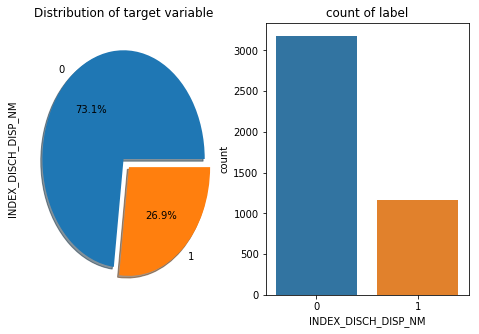

In [28]:
dis_label(data,label = "INDEX_DISCH_DISP_NM")

## Distribution of Numerical Variables

In [29]:
def c_distribution(df,col_name,title):
    facet = sns.FacetGrid(df, hue="INDEX_DISCH_DISP_NM",aspect=4)
    facet.map(sns.kdeplot,col_name,shade= True)
    facet.set(xlim=(0, data[col_name].max()))
    plt.subplots_adjust(top=0.9)
    facet.fig.suptitle(title)
    facet.add_legend()

### Length of stay distribution by labels

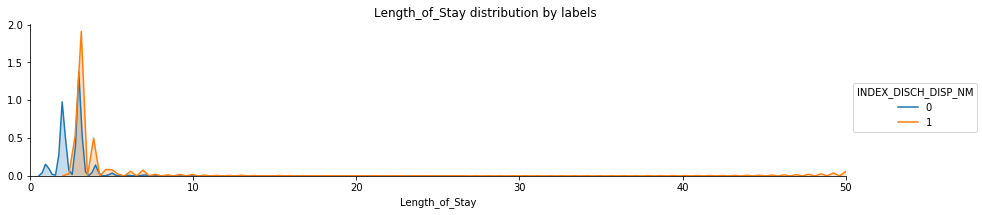

In [30]:
c_distribution(data,"Length_of_Stay","Length_of_Stay distribution by labels")

### Age distribution by labels

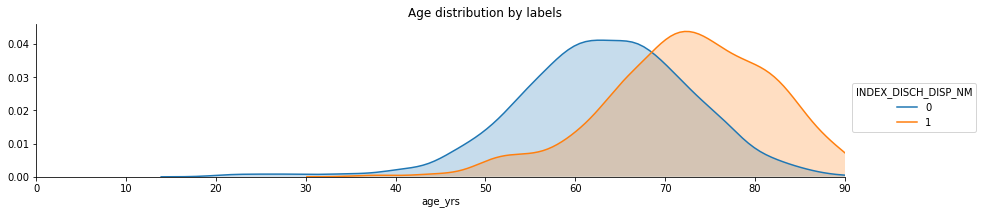

In [31]:
c_distribution(data,"age_yrs","Age distribution by labels")

### Weight Distribution by labels

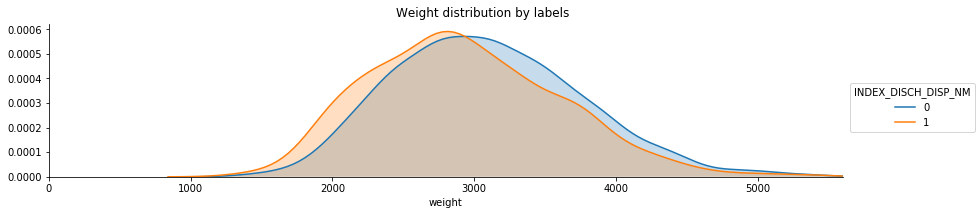

In [32]:
c_distribution(data,"weight","Weight distribution by labels")

### Height Distribution by labels

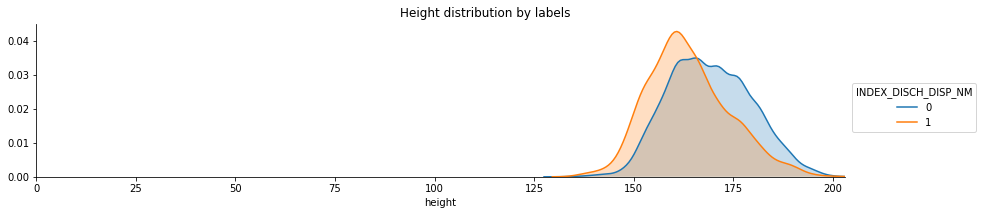

In [33]:
c_distribution(data,"height","Height distribution by labels")

## Distribution of Categorial Variables 

In [71]:
def c_plot(df, t1, t2, fontsize = 12):
    f,ax=plt.subplots(1,2,figsize=(15,8))
    df[[t1,t2]].groupby([t1]).count().plot.bar(ax=ax[0])
    ax[0].set_title("Count of label on " + t1)
    a = sns.countplot(t1,hue= t2, data= df,ax=ax[1])
    plt.rcParams["xtick.labelsize"] = fontsize
    plt.tight_layout()
    ax[1].set_title(t2 + " by label")
    plt.show()

### Service Date Year 

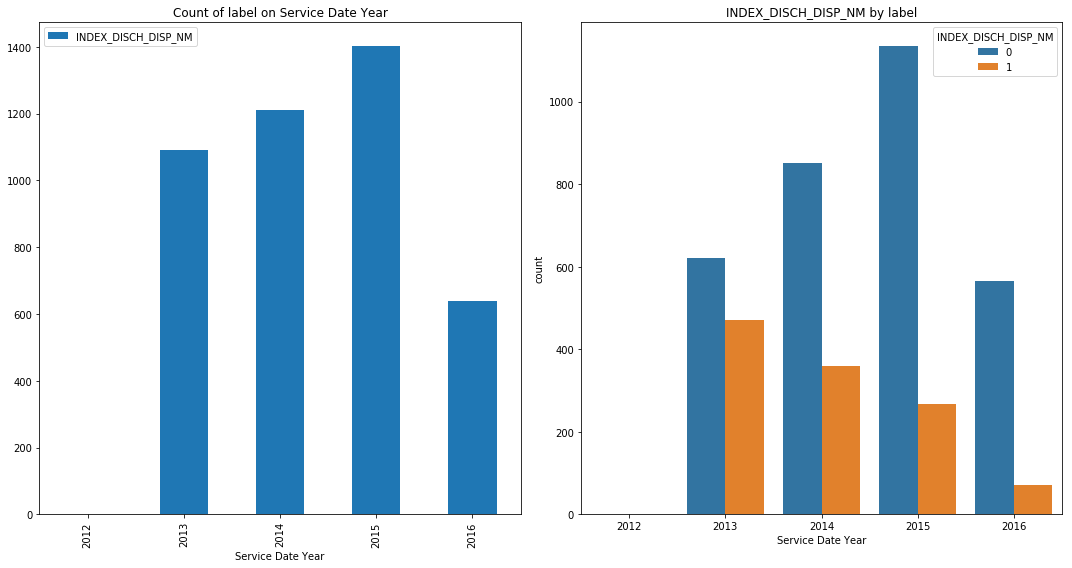

In [35]:
c_plot(data, "Service Date Year", "INDEX_DISCH_DISP_NM")

### Gender 

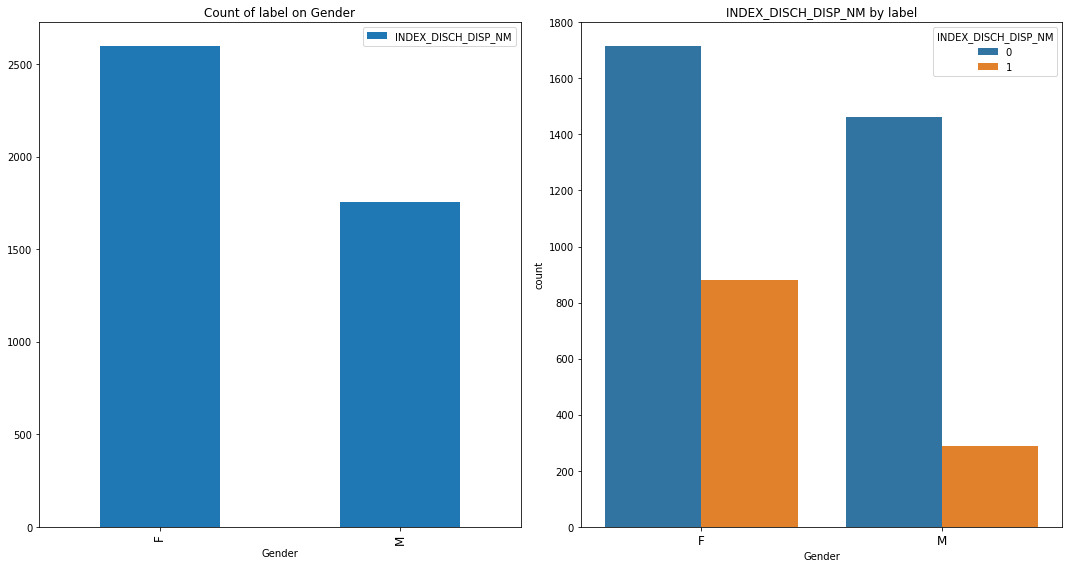

In [36]:
c_plot(data, "Gender", "INDEX_DISCH_DISP_NM")

### State

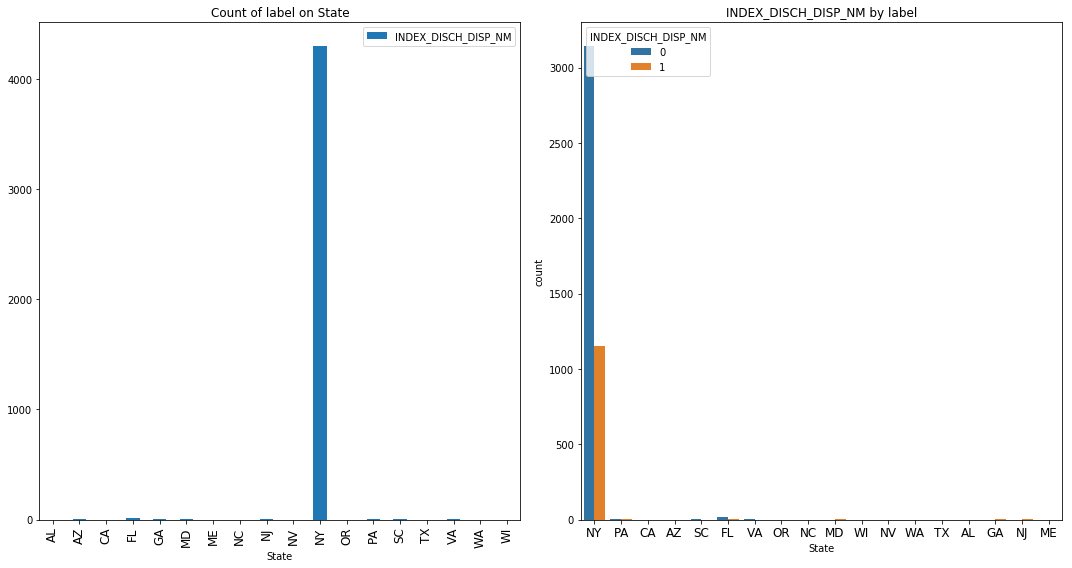

In [37]:
c_plot(data, "State", "INDEX_DISCH_DISP_NM")

### Pat_EthGrp 

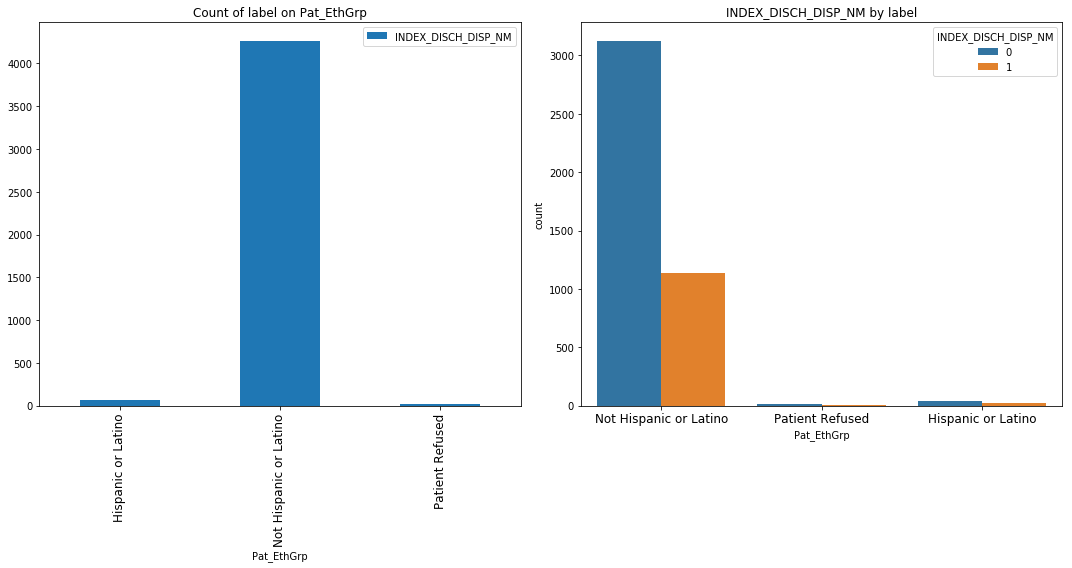

In [38]:
c_plot(data, "Pat_EthGrp", "INDEX_DISCH_DISP_NM")

### Pat_Race  

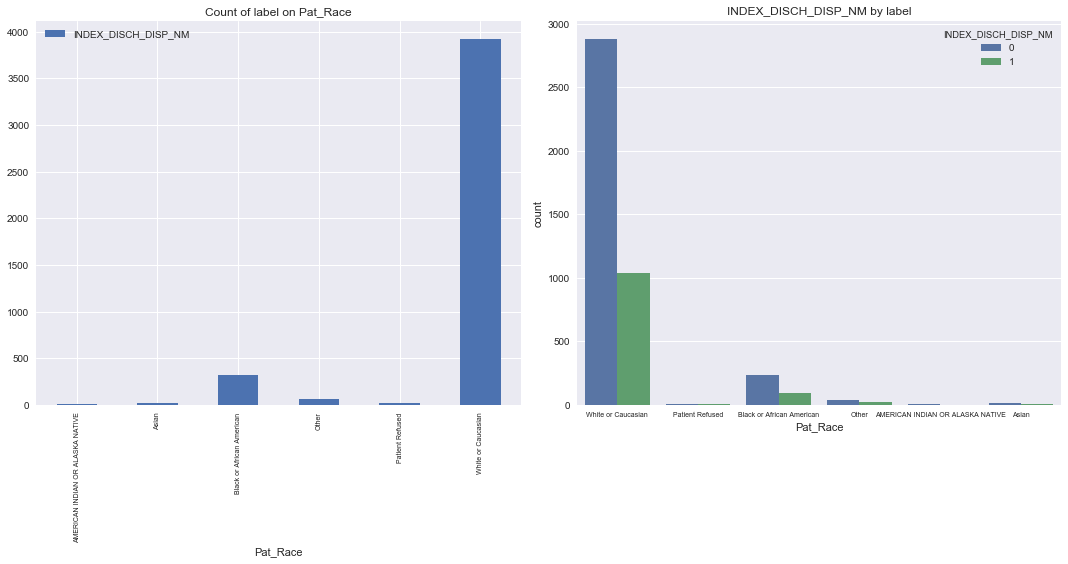

In [73]:
c_plot(data, "Pat_Race", "INDEX_DISCH_DISP_NM", fontsize= 6)

### Diag_1

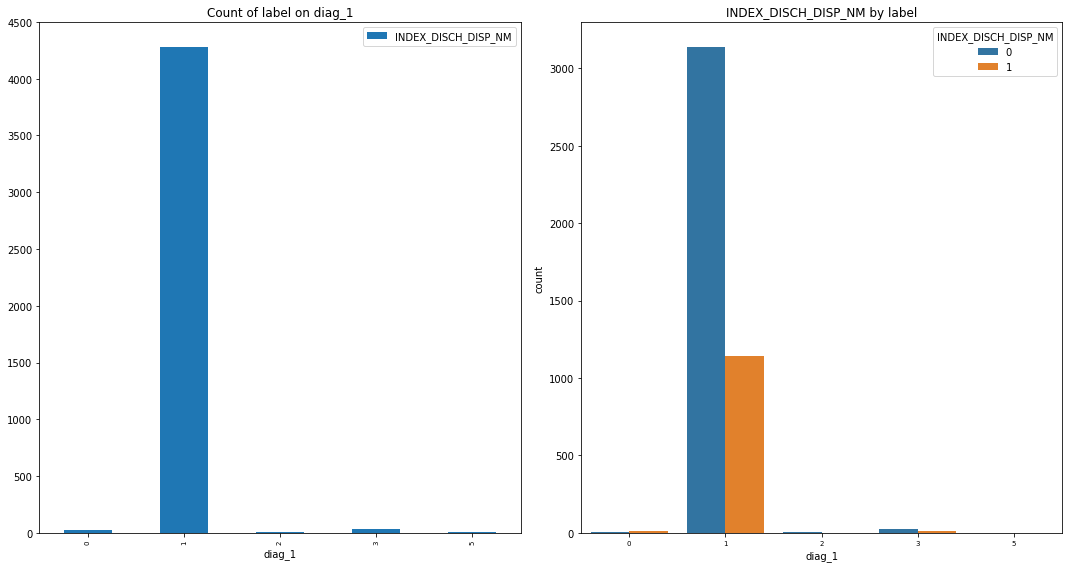

In [40]:
c_plot(data, "diag_1", "INDEX_DISCH_DISP_NM", fontsize= 16)

### ProcName_side 

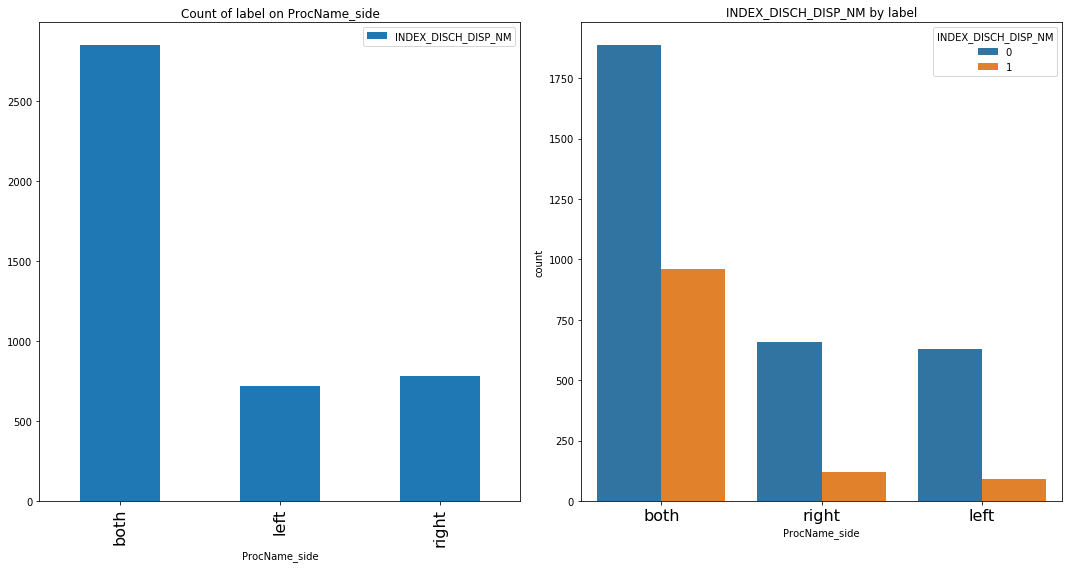

In [41]:
c_plot(data, "ProcName_side", "INDEX_DISCH_DISP_NM")

### ProcName_pos  

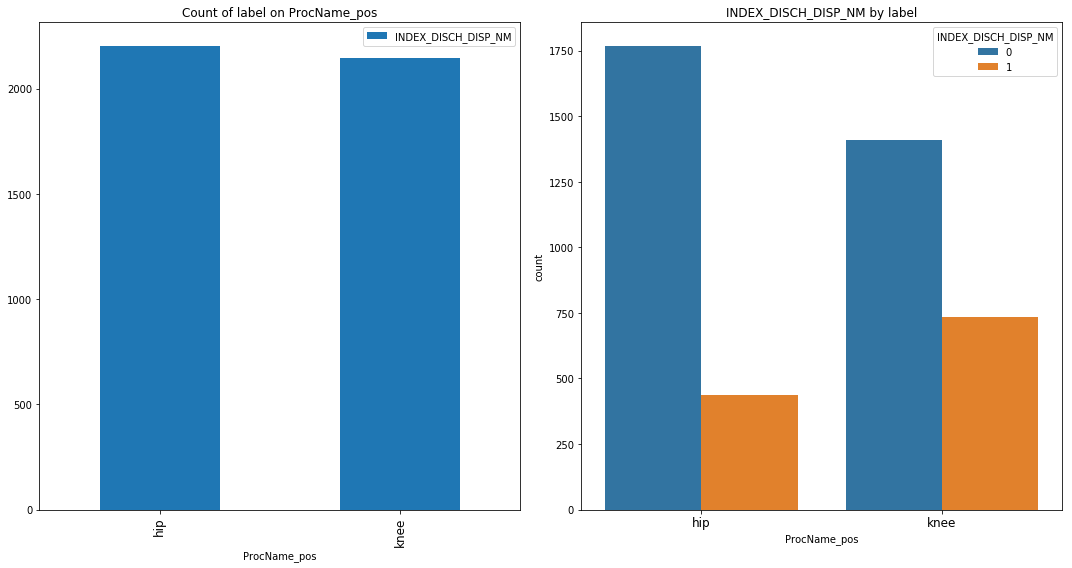

In [42]:
c_plot(data, "ProcName_pos", "INDEX_DISCH_DISP_NM")

### ProcName_anterior 

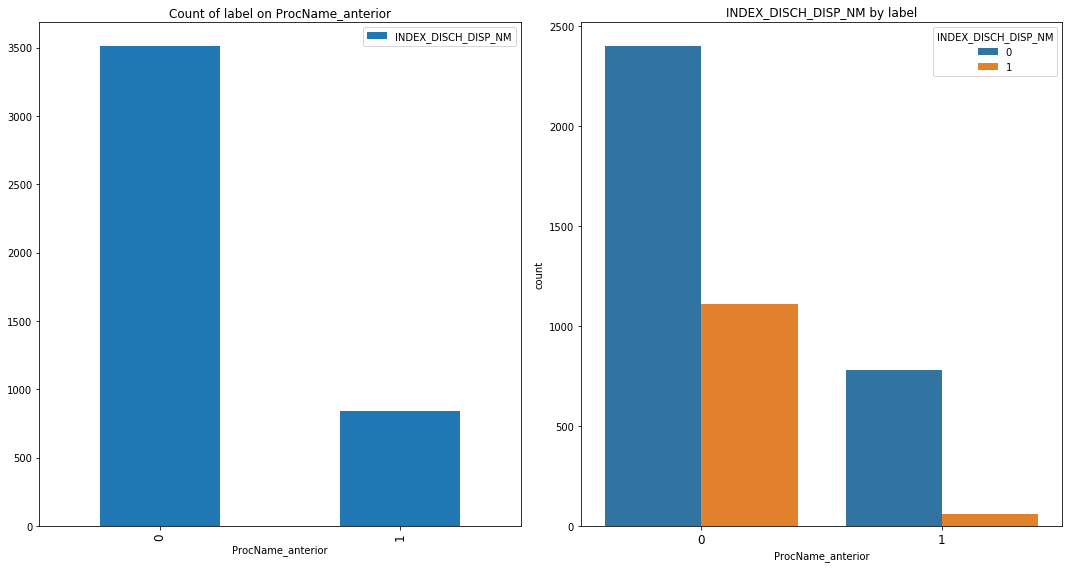

In [43]:
c_plot(data, "ProcName_anterior", "INDEX_DISCH_DISP_NM")

##  Correlation 

In [44]:
s1_column = [i for i in data.columns if data[i].dtype == "int" or data[i].dtype == "float"]
s1_column.remove("Patient_ID")

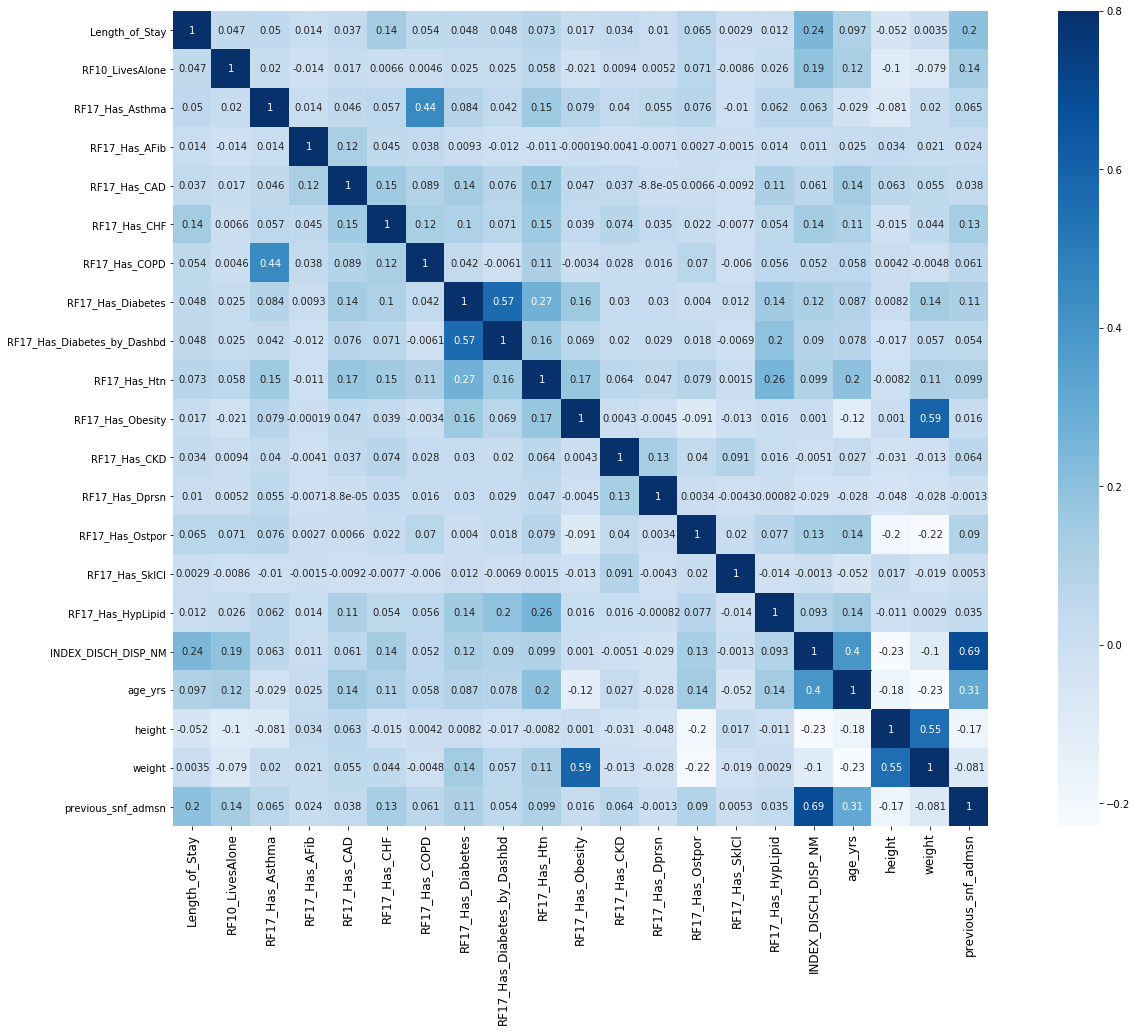

In [45]:
cor = data[s1_column].corr()
cor_plot = plt.subplots(figsize=(25, 15))
cor_plot = sns.heatmap(cor, vmax=.8, annot=True, square=True,cmap = "Blues")

***Summary***
- Only one strong correlation (r >0.6) was found between variables 

## Normality 

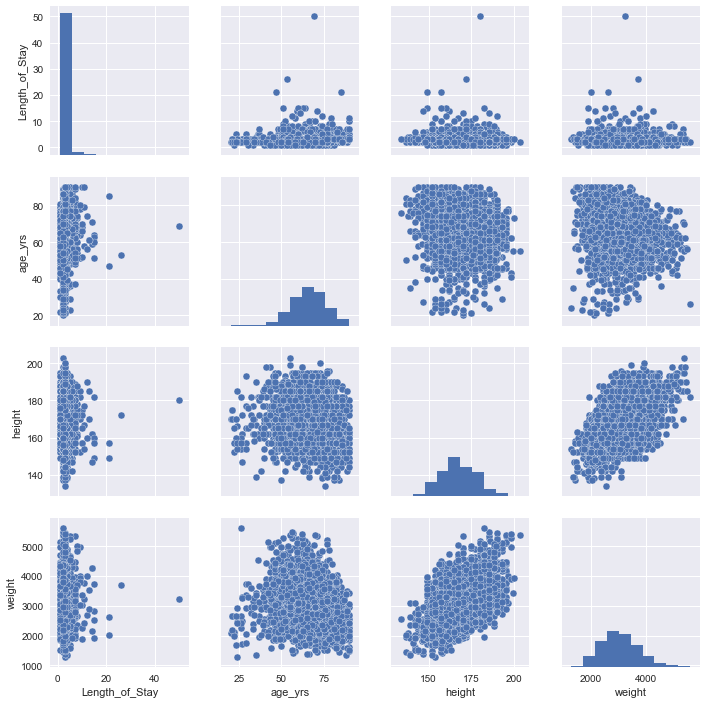

In [46]:
s1_column = [i for i in data.columns if data[i].dtype == "int" or data[i].dtype == "float"]
s2_column = ["Length_of_Stay",'age_yrs','height','weight']
sns.set()
sns.pairplot(data[s2_column], size = 2.5)
plt.show();

***Summary***
- Only a few continuous variables are chosen, given RF variables are binary 
- Length of stay is skewed left around 30
- Age years seems normally distributed, centered on 60-70 years
- height and weight are almost normally distributed after standarlization 

## Standarlization 

In [48]:
def standardize(data):
    return ((data - np.mean(data, axis = 0)) / np.std(data, axis = 0))

def standscale(df):
    col_name = ["weight","height","Length_of_Stay"]
    for c in col_name:
        df[c] = standardize(df[c])
    return df 

# Feature Selection 

In [55]:
def feature_selection(df):
    s_column = [i for i in data.columns if data[i].dtype == "int" or data[i].dtype == "float"]
    s_column.remove("Patient_ID")
    s_column.remove("age_yrs")
    print(len(s_column))
    return s_column
s = feature_selection(data)

20


In [56]:
# merge the dataset 
df_new = pd.concat([data[s],dfDummies],axis = 1)

In [57]:
df_new.isnull().sum().sum()

0

In [58]:
df_new.shape

(4347, 210)

# Train test sets split 

In [66]:
# split train, val and test dataset 
def train_validate_test_split(df, train_percent=.70, validate_percent=.15, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.loc[perm[:train_end]]
    validate = df.loc[perm[train_end:validate_end]]
    test = df.loc[perm[validate_end:]]
    return train, validate, test

train, validate, test = train_validate_test_split(df_new)
# save splitted datasets
train.to_csv("train.csv")
validate.to_csv("validate.csv")
test.to_csv("test.csv")

In [61]:
# split X, y
def split(data):
    """split X, y from the datasets"""
    x_col = list(set(list(train.columns)) - {"INDEX_DISCH_DISP_NM"})
    X = data[x_col]
    y = data["INDEX_DISCH_DISP_NM"]
    return X,y

X_train, y_train = split(train)
X_val, y_val = split(validate)
X_test, y_test = split(test)

In [62]:
# check the dataset splitting 
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(3042, 209) (3042,)
(652, 209) (652,)
(653, 209) (653,)


# Class Balance Checking 

Class 0: 2204
Class 1: 838
Proportion: 2.63 : 1


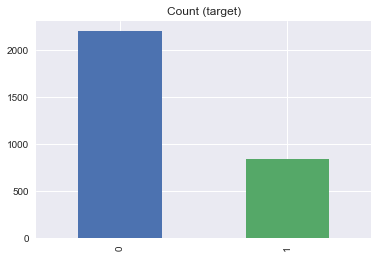

In [63]:
# Check the class for the outcome variable 
def class_balance(y_train):
    target_count= y_train.value_counts()
    print('Class 0:', target_count[0])
    print('Class 1:', target_count[1])
    print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

    target_count.plot(kind='bar', title='Count (target)')
    plt.show()
    
class_balance(y_train= y_train)

***Summary***
- The proportion of two classes is acceptable 

# Modeling 

In [64]:
def modeling(X_train,y_train,X_val,y_val,X_test,y_test):
    """classifiers for three models: logistic regression, svm, and random forest"""

    classifiers = [LogisticRegression(), 
                   svm.SVC(), 
                RandomForestClassifier()]

    for model in classifiers:
        print("model: ", model.__class__)
        model.fit(X_train,y_train)
        y_val_pred = model.predict(X_val)
        print("validation prediction result: ")
        print("validation accuracy result: {}".format(accuracy_score(y_val, y_val_pred)*100 ))
        print(confusion_matrix(y_val, y_val_pred))
        print(classification_report(y_val,  y_val_pred))
        print("test prediction result: ")
        y_test_hat = model.predict(X_test)
        print("test accuracy result: {}".format(accuracy_score(y_test, y_test_hat)*100))
        print(classification_report(y_test, y_test_hat))
    
    return

In [65]:
modeling(X_train,y_train,X_val,y_val,X_test,y_test)

model:  <class 'sklearn.linear_model.logistic.LogisticRegression'>
validation prediction result: 
validation accuracy result: 91.25766871165644
[[473  22]
 [ 35 122]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       495
           1       0.85      0.78      0.81       157

   micro avg       0.91      0.91      0.91       652
   macro avg       0.89      0.87      0.88       652
weighted avg       0.91      0.91      0.91       652

test prediction result: 
test accuracy result: 91.57733537519142
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       478
           1       0.87      0.81      0.84       175

   micro avg       0.92      0.92      0.92       653
   macro avg       0.90      0.88      0.89       653
weighted avg       0.91      0.92      0.91       653

model:  <class 'sklearn.svm.classes.SVC'>
validation prediction result: 
validation accuracy result: 75.9202453987

# Hyperparameter tuning 